<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 1: Clasificación</h4>
     <h5>Alumno: Federico Iza</h5>
</div>

# Clasificación de señales de radar

La siguiente celda importa varias librerías para utilizar. También se importan las variables de configuración del archivo ```tp1_radar_settings.py```.

In [70]:
import pandas as pd
from tp1_radar_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
import tensorflow as tf

La siguiente celda ejecuta la función ```config_plots()```, que cvonfigura un estilo para los gráficos con los parámetros que están especificados en ```utils/plot.py```.

In [71]:
%matplotlib inline
config_plots()

## Adquisición de datos

In [72]:
df = pd.read_csv('../data/ionosphere.data', header=None)

In [73]:
col_names = []
for i in range(1, N_SIGNALS+1):
    for suffix in ['R', 'I']:
        col_names.append(f'F{str(i)}{suffix}')
col_names.append('Target')
df.columns = col_names

In [74]:
df.head()

,F1R,F1I,F2R,F2I,F3R,F3I,F4R,F4I,F5R,F5I,...,F13I,F14R,F14I,F15R,F15I,F16R,F16I,F17R,F17I,Target
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


## Preprocesamiento de datos

Hay que transformar la columna 'Target' a valores numéricos para poder utilizarla en el modelo.

In [75]:
# Numerical data has to be used in ANNs
category_target = {'g': 1, 'b': 0}
df['Target'] = df['Target'].map(category_target)

In [76]:
df.describe()

,F1R,F1I,F2R,F2I,F3R,F3I,F4R,F4I,F5R,F5I,...,F13I,F14R,F14I,F15R,F15I,F16R,F16I,F17R,F17I,Target
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,...,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480,0.641026
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,...,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337,0.480384
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,...,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350,0.000000
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,...,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000,1.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,...,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660,1.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Ingeniería de datos

### ¿Están los datos balanceados?

In [77]:
data_balace = df['Target'].value_counts()
print(data_balace)

1    225
0    126
Name: Target, dtype: int64


El resultado anterior indica que los datos *no* están balanceados; hay 225 eventos detectados como ecos positivos mientras que hay 126 detectado como ecos negativos.

Para baleancear los datos, se pueden eliminar los primeros 99 ecos positivos.

In [78]:
# Remove data to balance dataset
counter = 99  # Remove the first 99 rows with target=1
df_aux = pd.DataFrame()
for idx, row in df.iterrows():
    if counter > 0:
        if row['Target'] == 1:
            counter -= 1
        else:
            df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                               axis=0,
                               ignore_index=True)
    else:
        df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                           axis=0,
                           ignore_index=True)

In [79]:
data_balace = df_aux['Target'].value_counts()
print(data_balace)

0.0    126
1.0    126
Name: Target, dtype: int64


Ahora tenemos la misma cantidad de ecos positivos como negativos en el dataset.

## Preparación de datos

A continuación se generan dos datasets, uno contiene los features a utilizarse para la predición y el otro el target.

In [80]:
features = df_aux.loc[:, df_aux.columns != 'Target']
target =  df_aux.loc[:, df_aux.columns == 'Target']

## Modelado

En primer lugar, se separa la muestra en el grupo de entrenamiento y el grupo de testeo. El tamaño de testeo está almacenado en la variable ```TEST_SIZE``` y es común a todos los modelos utilizados.

In [81]:
print(TEST_SIZE)

0.2


In [82]:
(feats_train, feats_test,
 target_train, target_test) = train_test_split(features, target,
                                               test_size=TEST_SIZE)

In [83]:
input_size = feats_train.shape[1]  # Number of feats for training

En la celda siguiente se construye la arquitectura de la red neuronal, configurando la cantida de capas (```N_LAYERS```), la cantidad de neuronas en cada capa (```N_NEURONS```), la función de pérdida (```LOSS_FUNCTION```) y el optimizador (```OPTIMIZER```).

In [84]:
# Define ANN architecture
models = []

for i in range(len(models_params.keys())):
    # Instance the model
    model = Sequential()

    for j in range(models_params[f'm{i}']['N_LAYERS']):
        model.add(Dense(units=models_params[f'm{i}']['N_NEURONS'][j],
                        input_dim=input_size))
        model.add(Activation(models_params[f'm{i}']['ACTIVATION_FUNCTIONS'][j]))

    # Complile model
    model.compile(loss=LOSS_FUNCTION,  # Select loss function
                  optimizer=OPTIMIZER,  # Select optimizer
                  metrics=[tf.keras.metrics.Accuracy()])

    # Append model to list of models
    models.append(model)

La siguiente celda entrena la red neuronal, indicando el número de épocas a utilizar (```N_EPOCHS```) y el tamaño del set de validación (```VALIDATION_SPLIT```).

In [85]:
histories = []
for i in range(len(models_params.keys())):
    history = models[i].fit(feats_train, target_train,
                            epochs=models_params[f'm{i}']['N_EPOCHS'],
                            validation_split=VALIDATION_SPLIT,
                            verbose=0)
    histories.append(history)

In [86]:
# Calculate the upper limit of the x-axis
xmax = models_params['m0']['N_EPOCHS']
for i in range(len(models_params.keys())):
    if models_params[f'm{i}']['N_EPOCHS'] > xmax:
        xmax = models_params[f'm{i}']['N_EPOCHS']

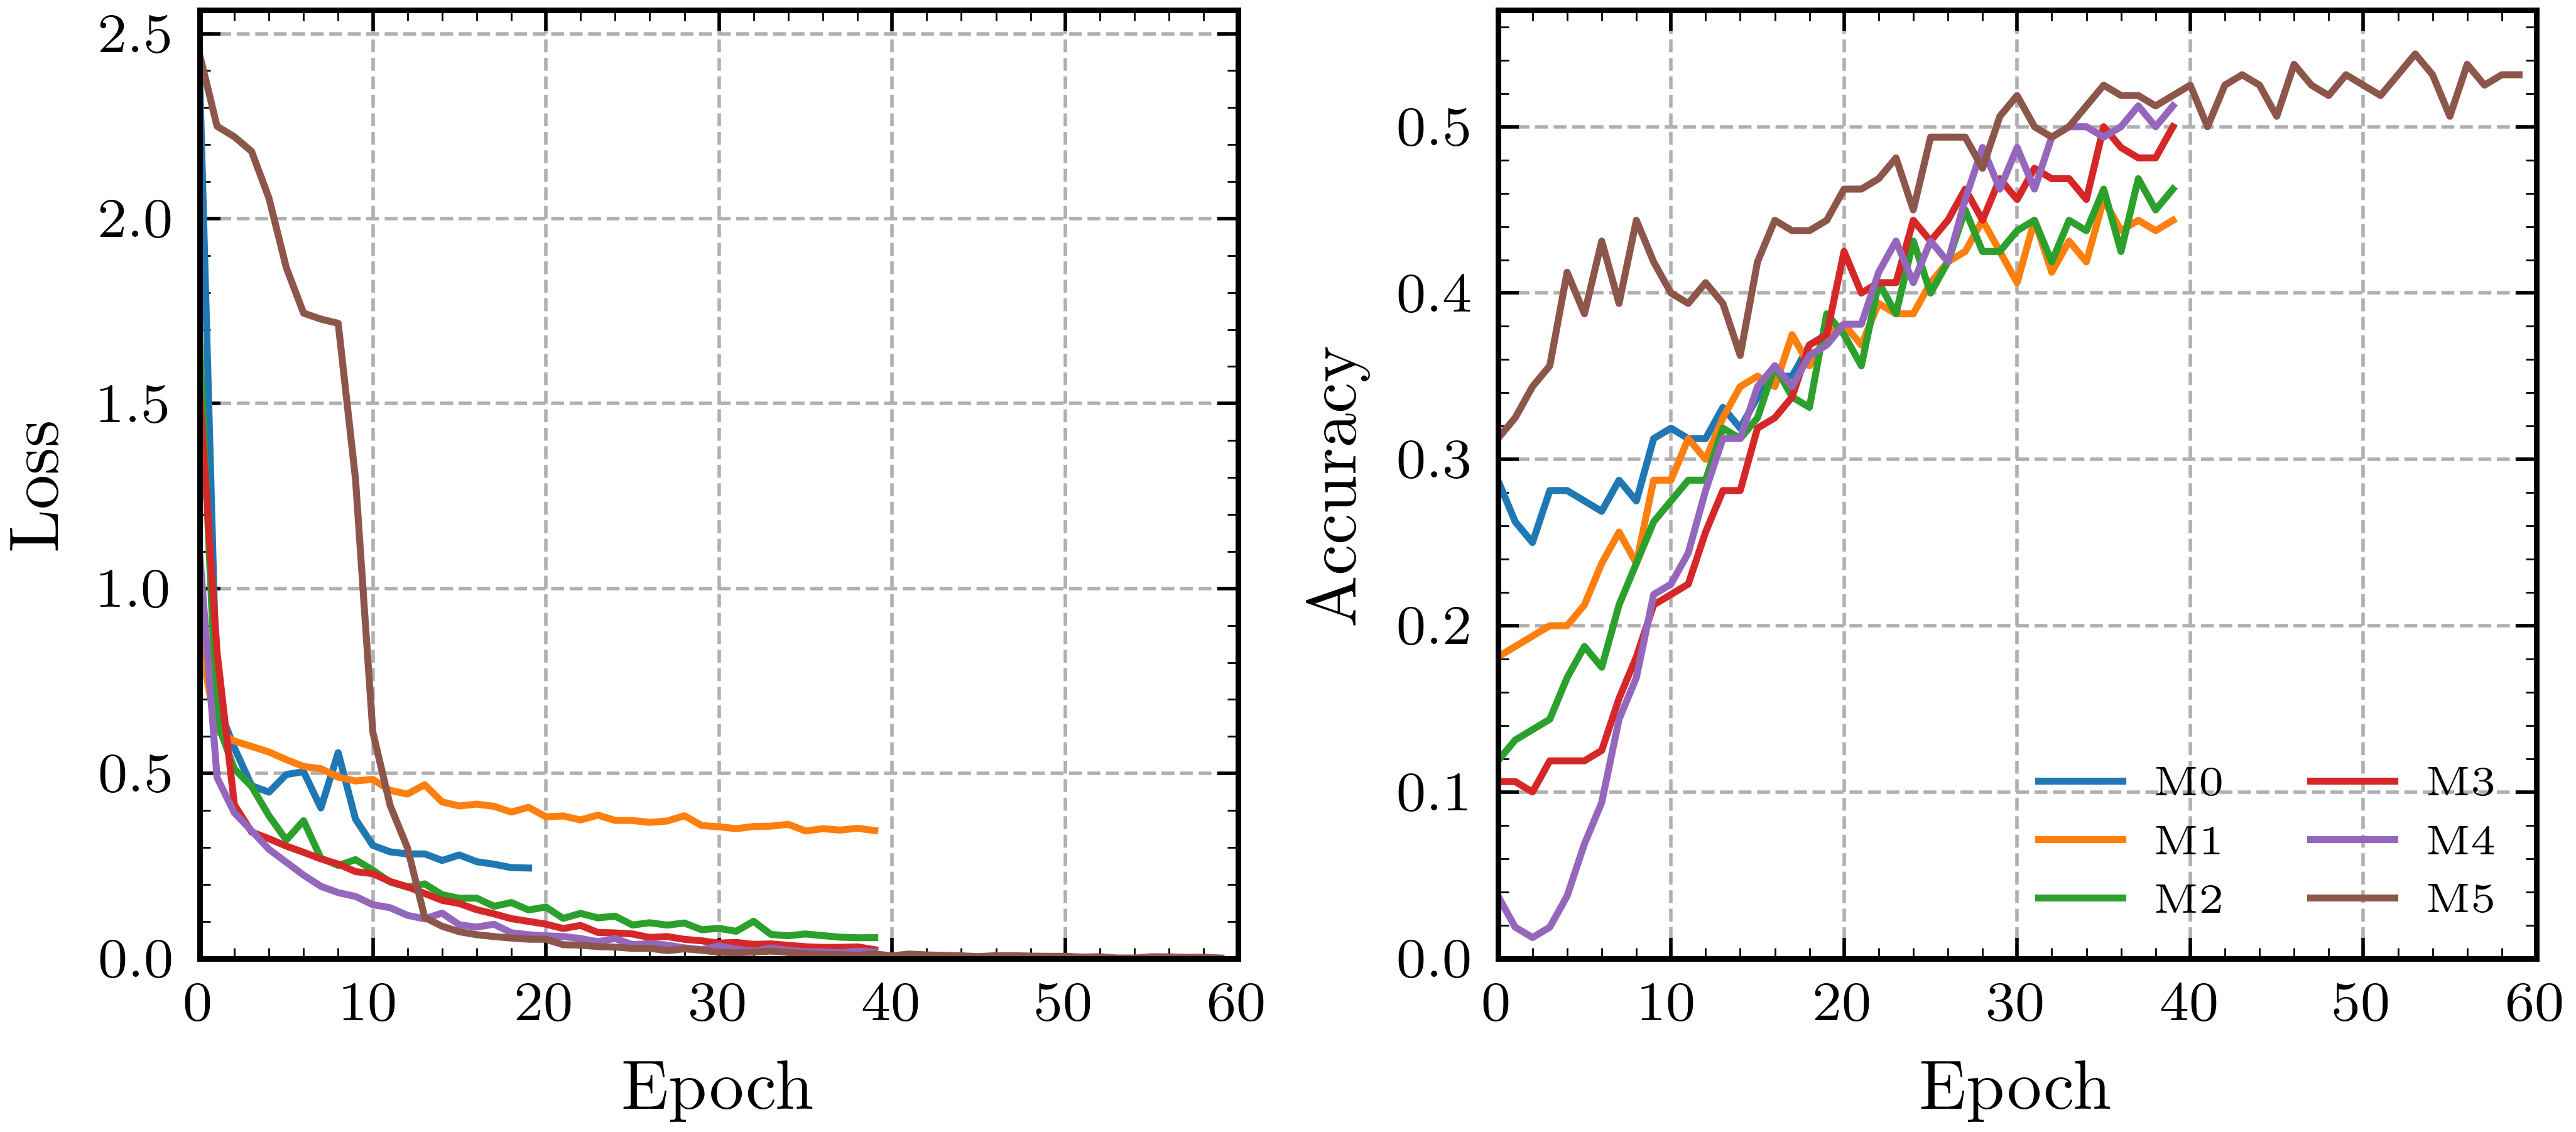

In [93]:
fig = plt.figure(figsize=(6, 2.5), facecolor='white')
gs = fig.add_gridspec(ncols=2, nrows=1, hspace=0, wspace=.25)
axs = gs.subplots(sharex=True, sharey=False)

for ax in axs:
    ax.tick_params(which='both', direction="in")
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', lw=.5)
    ax.minorticks_on()
    ax.set_xlabel('Epoch')
    ax.set_xlim(0, xmax)

# Loss
axs[0].set_ylabel('Loss')
for i in range(len(models_params.keys())):
    axs[0].plot(histories[i].history['loss'],
                color=models_params[f'm{i}']['COLOR'],
                ls='-', lw=1, label=f'M{i}')
    # axs[0].plot(histories[i].history['val_loss'],
    #             color=models_params[f'm{i}']['COLOR'],
    #             ls='--',  lw=1, label=f'M{i}_ValLoss')

# Accuracy
axs[1].set_ylabel('Accuracy')
for i in range(len(models_params.keys())):
    axs[1].plot(histories[i].history['accuracy'],
                color=models_params[f'm{i}']['COLOR'],
                ls='-', lw=1, label=f'M{i}')
    # axs[1].plot(histories[i].history['val_accuracy'],
    #             color=models_params[f'm{i}']['COLOR'],
    #             ls='-', lw=1, label=f'M{i}_ValAccuracy')
axs[1].legend(framealpha=0, ncol=2)

for ax in axs:
    ax.set_ylim(0, ax.get_ylim()[1])

fig.savefig('../images/tp1_fig1.pdf')
plt.show()

## Clasificación y validación

La siguiente celda utiliza el dataset de prueba para general predicciones utilizando el modelo entrenado.

In [88]:
y_preds = []
for i in range(len(models_params.keys())):
    y_preds.append(models[i].predict(feats_test))

2/2 [==============================] - 0s 2ms/step


Para la predicción y el target del dataset de prueba, se calcula la matriz de confusión.

In [89]:
# Assign all values greater than 1 to 1
y_preds = np.array(y_preds)
y_preds[y_preds > 1] = 1.0

In [90]:
cms = []
for i in range(len(models_params.keys())):
    cms.append(confusion_matrix(np.round(y_preds[i]),
                                target_test,
                                labels=[0., 1.]))

In [91]:
# Confusion matrix structure
# TN | FP
# FN | TP

# Print confusion matrices
for i in range(len(models_params.keys())):
    print(f'Model M{i}:')
    for row in cms[i]:
        print('\t\t\t' + ' '.join(map(str, row)))

Model M0:
			15 2
			6 28
Model M1:
			14 1
			7 29
Model M2:
			17 1
			4 29
Model M3:
			16 2
			5 28
Model M4:
			18 1
			3 29
Model M5:
			20 2
			1 28


Se calcula además, el *accuracy score* de los modelos.

In [92]:
# print(np.diag(cm).sum() / cm.sum())
for i in range(len(models_params.keys())):
    print(f'Model M{i}:\t', end='')
    print(accuracy_score(target_test, np.round(y_preds[i])))

Model M0:	0.8431372549019608
Model M1:	0.8431372549019608
Model M2:	0.9019607843137255
Model M3:	0.8627450980392157
Model M4:	0.9215686274509803
Model M5:	0.9411764705882353
